In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Read in the calibration data
calib_df = pd.read_csv('Beach6_2019_calibration_data.csv')

In [22]:
y_calib = calib_df['ECOLI_LOG10'] #target

# Features
calib_df['LOG_TURB'] = np.log10(calib_df['TURB_NTRU'])
calib_df['SQRT_RAIN48'] = np.sqrt(calib_df['AirportRain48W_in']) 
X_calib = calib_df[['LOG_TURB', 'RHUM_PCT', 'WTEMP_CEL',
                    'BIRDS_NO', 'CHANGELL_FT',
                    'AirportWindSpInst_mph', 'SQRT_RAIN48']]


In [23]:
# Using Ridge Regularization and Cross Validation
model = Ridge()
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)


param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]} 
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=k_fold, scoring='r2')

# Fitting the Model
grid_search.fit(X_calib, y_calib)

print(f"Best hyperparameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_}")


Best hyperparameters: {'alpha': 1}
Best cross-validation score: 0.4498080743449651


In [24]:
# Evaulation
best_model = grid_search.best_estimator_
best_model.fit(X_calib, y_calib)

# Coefficient Table 
coefficient_df = pd.DataFrame({ 'Feature': X_calib.columns, 'Fitted Coefficient': best_model.coef_ })
intercept_df = pd.DataFrame({ 'Feature': ['Intercept'], 'Fitted Coefficient': [best_model.intercept_] })
coeff_table = pd.concat([intercept_df, coefficient_df], ignore_index=True)
print("\nModel Coefficients:")
print(coeff_table)

y_calib_pred = best_model.predict(X_calib)

mean_squared_e = mean_squared_error(y_calib, y_calib_pred) 
rmse = np.sqrt(mean_squared_e) 
r2 = r2_score(y_calib, y_calib_pred) 

print("")
print("Evaluation Metrics:")
print(f"\tR Squared:\t\t{r2:.4e}")
print(f"\tRMSE:\t\t\t{rmse:.4e}") 


Model Coefficients:
                 Feature  Fitted Coefficient
0              Intercept           -1.003045
1               LOG_TURB            0.671373
2               RHUM_PCT            0.007908
3              WTEMP_CEL            0.052585
4               BIRDS_NO            0.001799
5            CHANGELL_FT            0.306544
6  AirportWindSpInst_mph            0.025096
7            SQRT_RAIN48            0.199466

Evaluation Metrics:
	R Squared:		4.7653e-01
	RMSE:			4.8010e-01


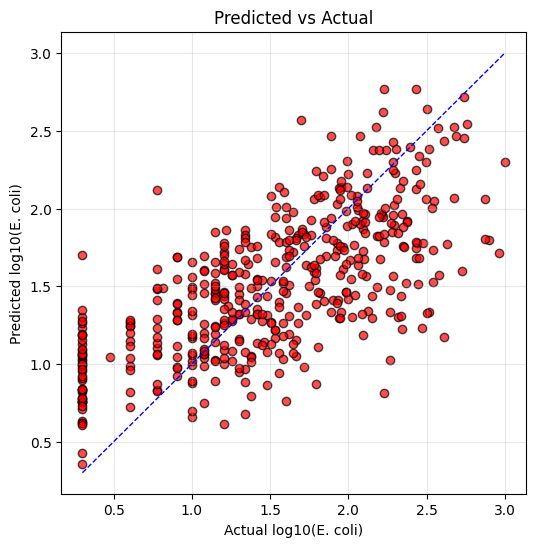

In [25]:
# Plot
plt.figure(figsize=(6,6))
plt.scatter(y_calib, y_calib_pred, alpha=0.7, color='red', edgecolors='k')
lims = [min(y_calib.min(), y_calib_pred.min()), max(y_calib.max(), y_calib_pred.max())]
plt.plot(lims, lims, 'b--', linewidth=1)
plt.xlabel("Actual log10(E. coli)")
plt.ylabel("Predicted log10(E. coli)")
plt.title("Predicted vs Actual")
plt.grid(True, alpha=0.3)
plt.show()

In [26]:
# (Optional) csv table of the values

compare_df = pd.DataFrame({
    'Observed': y_calib.values.flatten(),
    'Predicted': y_calib_pred.flatten()
    
})
compare_df.round(4).to_csv('beach_observed_vs_predicted.csv')

In [28]:
# Attempt On Using Validation Data 
valid_df = pd.read_excel('Beach6_validation_spreadsheet_2019.xlsx')

# Target 
y_valid = valid_df["LAB_ECOLI"].replace('<1', 0.5).astype(float)
y_valid_log = np.log10(y_valid + 1)

# Features 
valid_df['LOG_TURB'] = np.log10(valid_df['TURB_NTRU'])
valid_df['SQRT_RAIN48'] = np.sqrt(valid_df['AirportRain48W_in']) #USGS model uses square root

X_valid = valid_df[['LOG_TURB', 'RHUM_PCT', 'WTEMP_CEL',
                    'BIRDS_NO', 'CHANGELL_FT',
                    'AirportWindSpInst_mph', 'SQRT_RAIN48']]

/tmp/ipykernel_228012/406493333.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_valid = valid_df["LAB_ECOLI"].replace('<1', 0.5).astype(float)


In [29]:
# Evaluation
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_valid)
rmse = np.sqrt(mean_squared_error(y_valid_log, y_pred))
r2 = r2_score(y_valid_log, y_pred)

print("Evaluation Metrics:")
print(f"\tR Squared:\t\t{r2:.4e}")
print(f"\tRMSE:\t\t\t{rmse:.4e}")

Evaluation Metrics:
	R Squared:		2.5306e-01
	RMSE:			4.8938e-01


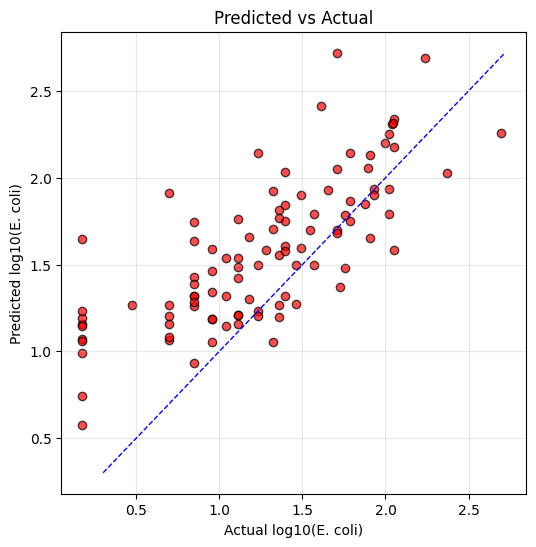

In [30]:
# Plot
plt.figure(figsize=(6,6))
plt.scatter(y_valid_log, y_pred, alpha=0.7, color='red', edgecolors='k')
lims = [min(y_calib.min(), y_pred.min()), max(y_valid_log.max(), y_pred.max())]
plt.plot(lims, lims, 'b--', linewidth=1)  # 1:1 line
plt.xlabel("Actual log10(E. coli)")
plt.ylabel("Predicted log10(E. coli)")
plt.title("Predicted vs Actual")
plt.grid(True, alpha=0.3)
plt.show()